Inspired by : https://aawiegel.github.io/independence-and-sampling-in-experimental-design.html

Data from: https://github.com/aawiegel/PowerSimulationDemo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
import math
import scipy.stats as stats

## The Data

In [2]:
df = pd.read_csv('synthetic_data.csv')

In [4]:
df.head()

,synthesis_id,well_position,pure_yield,full_length_product,n-1,n+1,cyanoethyl,other_impurity,well_position_label
0,1,0,32.137910,67.216778,4.681915,7.522566,2.143953,1.794738e-293,A1
1,1,1,34.102792,66.812247,3.046022,3.841760,1.748832,0.000000e+00,A2
2,1,2,36.291145,65.550430,5.348962,4.746564,2.536760,4.552129e-112,A3
3,1,3,31.898187,64.316842,4.468409,2.734823,1.598658,0.000000e+00,A4
4,1,4,31.898228,66.387917,7.550588,2.743191,1.564808,0.000000e+00,A5


## EDA: Are feature distributions normal?

In [5]:
cols_to_plot = ['pure_yield', 'full_length_product',
       'n-1', 'n+1', 'cyanoethyl', 'other_impurity']

Seaborn's `distplot` has built-in `fit` function

/Users/kendra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


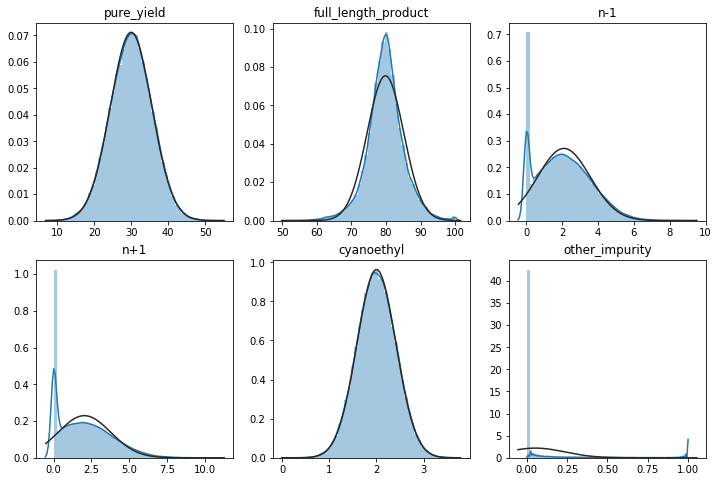

In [6]:
fig = plt.subplots(2,3, figsize=(12,8))
i = 1
for col in cols_to_plot:
    plt.subplot(2,3,i)
    sns.distplot(df[col].values, fit=scipy.stats.distributions.norm)
    plt.title(col)
    i += 1

#### Aside: trying to manually fit histogram to Gaussian

In [26]:
hist1, edges1 = np.histogram(df['pure_yield'], bins = int(num_bins), density=True)

In [36]:
def gaus_fn(x, u, sd):
    return (1 / 2 * math.pi * sd**2) * np.exp(-(x - u)**2 / 2 * sd**2)

In [50]:
fit_data = scipy.optimize.curve_fit(gaus_fn, edges1[1:], hist1, p0 = [30, 5])
fit_data

(array([30.17534015,  0.21461466]), array([[8.68229920e-03, 9.22271692e-12],
        [9.22271692e-12, 3.34895777e-06]]))

In [51]:
sim_data = [gaus_fn(x, fit_data[0][0], fit_data[0][1]) for x in xs1]

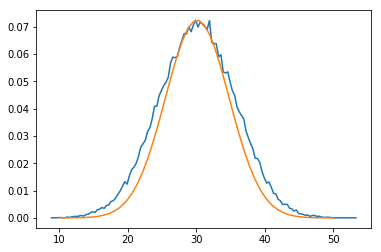

In [53]:
# sns.distplot(df['pure_yield'], norm_hist=True)
plt.plot(edges1[1:], hist1)
plt.plot(xs1, sim_data);

Plot best-guess at a Normal curve based on data's mean & std dev, and print scipy's normal test result p-value

In [78]:
def plot_normal_guess(col, mu=None, sd=None):
    data = df[col]
    xs = np.linspace(min(data), max(data))
    if not mu:
        mu = np.mean(data)
    if not sd:
        sd = np.std(data)
        
    sns.distplot(data.values, norm_hist=True)
    plt.plot(xs, scipy.stats.norm.pdf(xs, mu, sd))
    plt.title(col)
    print(f'Normal test p-value: {scipy.stats.normaltest(data).pvalue}')

Normal test p-value: 3.405216889993005e-05


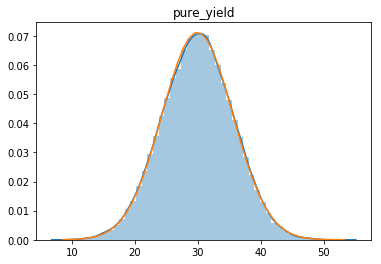

In [79]:
plot_normal_guess('pure_yield')

Normal test p-value: 0.0


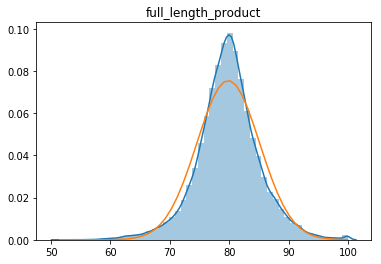

In [80]:
plot_normal_guess('full_length_product')

Normal test p-value: 1.7045803509943013e-05


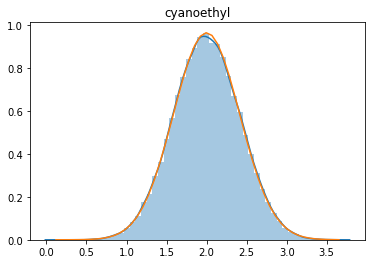

In [81]:
plot_normal_guess('cyanoethyl')

## EDA: are features correlated?

I find Seaborn's corrplot to be memory-intensive. Use a matplotlib's `matshow` instead. (Note mpl's `scatter_matrix` is equally slow.)

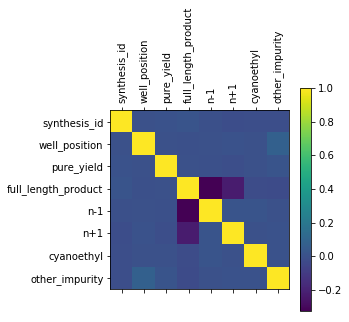

In [13]:
plt.matshow(df.corr())
plt.xticks(ticks=range(len(df.columns[:-1])), labels=list(df.columns[:-1]), rotation=90)
plt.yticks(ticks=range(len(df.columns[:-1])), labels=list(df.columns[:-1]))
plt.colorbar();

## Diving deeper

Group by synthesis

In [20]:
df_synth = df.groupby(by='synthesis_id')['pure_yield', 'full_length_product'].aggregate(np.mean)

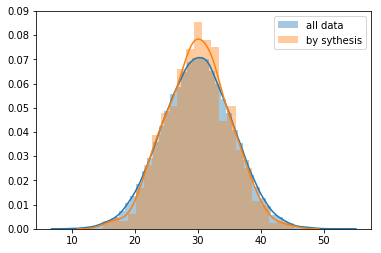

In [24]:
sns.distplot(df['pure_yield'].values, label='all data')
sns.distplot(df_synth['pure_yield'].values, label='by sythesis')
plt.legend();

/Users/kendra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


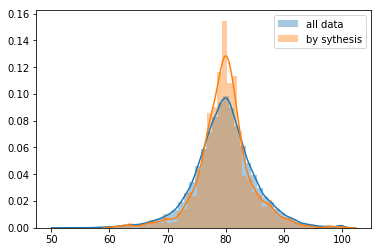

In [28]:
sns.distplot(df['full_length_product'].values, label='all data')
sns.distplot(df_synth['full_length_product'].values, label='by sythesis')
plt.legend();

In [27]:
stats.normaltest(df_synth['pure_yield'])

NormaltestResult(statistic=0.4379217473513711, pvalue=0.803353149794598)

### But is this what we expect?

Grouping by synthesis results in a slightly narrower distribution, which fails the normal test. But how does it compare to a random grouping of 96 wells? The latter demonstrates the Central Limit Theorem:

In [29]:
random_data = []

for _ in range(1000):
    sample = df.sample(n=96)
    
    data = {
        'pure_yield': sample['pure_yield'].mean(),
        'full_length_product': sample['full_length_product'].mean()
    }
    
    random_data.append(data)

df_resampled = pd.DataFrame(random_data)

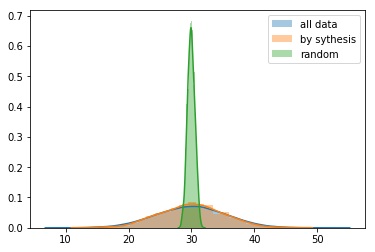

In [33]:
sns.distplot(df['pure_yield'].values, label='all data')
sns.distplot(df_synth['pure_yield'].values, label='by sythesis')
sns.distplot(df_resampled['pure_yield'].values, label='random')
plt.legend();

In [37]:
np.std(df_resampled['pure_yield'])

0.5790613454894296

expected std = std of original dataset / sqrt of n (where n = sample size = 96)

In [38]:
np.std(df['pure_yield']) / np.sqrt(96)

0.5720982554511296

Thus, one synthesis (a 96-well plate) is *not* a random sample. When comparing experimental variables, must treat entrie plate / synthesis as n=1 (not n=96). 